In [243]:
import importlib
from pathlib import Path

import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from numpy.random import default_rng
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from fopra import fopra_driver
from mapra import prep

sns.set_theme(style='white')
cmap = sns.color_palette('viridis', 3)
dmap = sns.color_palette('rocket', 4)

rng = np.random.default_rng(12345)
WD = Path('.').resolve().parent

In [246]:
importlib.reload(prep)
importlib.reload(fopra_driver)
data = prep.dataset()
df = data.dataframe_abbrev(reduced=True)
dataset_sizes = dict(df['DELTA'].value_counts())

for i, delta in enumerate(data.order):
    dataset_sizes[float(i)] = dataset_sizes.pop(delta)

test_size = .2
seed = 35

splits = data.uniprot_train_test_split(df=df, test_size=.2, random_state=seed)
fopra_driver.seeds, dataset_sizes

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:42: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:53: UserWarning: found not exactly one TSV with annotations:
/home/quirin/PYTHON/mapra/wildtype_pHs.tsv
/home/quirin/PYTHON/mapra/prothermdb_annotations.tsv
/home/quirin/PYTHON/mapra/wildtypes.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb.tsv
/home/quirin/PYTHON/mapra/txts/uniprot_to_pdb_unmapped.tsv
/home/quirin/PYTHON/mapra/full_dbs/crop.tsv
/home/quirin/PYTHON/mapra/full_dbs/wild_types.tsv
/home/quirin/PYTHON/mapra/full_dbs/wildtypes.tsv
/home/quirin/PYTHON/mapra/full_dbs/Tm_dataset.tsv
/home/quirin/PYTHON/mapra/CAGI6/cam_predictions.tsv
  warnings.warn('found not exactly one TSV with annotations:\n' + '\n'.join(str(tsv) for tsv in tsvs))


loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl
split 35 targeted 0.2, real test sizes: 0.2020:0.2113:0.2057, record test sizes: 0.3623:0.1307:0.0980


([0, 1, 2], {0.0: 5098, 1.0: 1943, 2.0: 5040})

In [221]:
ar = np.load(str(WD / 'txts' / f'fopra_all.npy'),
             allow_pickle=False)
df = pd.DataFrame(ar, columns=['delta', 'abs_set_size', 'n_cols', 'rmse', 'sp', 'pval',
                               'alpha', 'r2', 'pcorr', 'seed', 'algo',
                               'set_size', 'real_test_size', 'records_test_size'])
# calculate a theoretical x value so we have multiple observations for a single x
df['x'] = df.apply(axis=1, func=lambda gdf: dataset_sizes[gdf.delta] * (1 - test_size) * gdf.set_size)
df.delta = df.delta.apply(lambda d: data.tex_lookup[data.order[int(d)]])
largest_n_cols = sorted(set(df.n_cols))[-2]
df

,delta,abs_set_size,n_cols,rmse,sp,pval,alpha,r2,pcorr,seed,algo,set_size,real_test_size,records_test_size,x
0,ΔT$_{\mathrm{m}}$,942.0,87.0,5.776374e+00,0.316256,3.124125e-32,0.013782,-8.425880e-02,0.281077,0.0,0.0,0.25,0.202020,0.260494,1019.60
1,ΔΔG,405.0,108.0,2.435148e+00,0.025400,6.487396e-01,0.002882,-9.266267e-02,0.133198,0.0,0.0,0.25,0.211268,0.166752,388.60
2,ΔΔG$_{\mathrm{H_2O}}$,1082.0,233.0,2.275615e+00,0.249747,1.337345e-11,0.000970,-6.169547e-02,0.224372,0.0,0.0,0.25,0.205674,0.141468,1008.00
3,ΔT$_{\mathrm{m}}$,3770.0,352.0,6.789832e+00,0.310328,4.884032e-31,0.001004,-4.980985e-01,0.327019,0.0,0.0,1.00,0.202020,0.260494,4078.40
4,ΔΔG,1619.0,225.0,2.240008e+00,0.220843,6.086534e-05,0.000562,7.544077e-02,0.347981,0.0,0.0,1.00,0.211268,0.166752,1554.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,ΔΔG,177.0,1024.0,5.502625e+11,0.026177,7.332063e-01,0.000000,-8.258268e+22,0.009274,1029.0,3.0,0.10,0.211268,0.088523,155.44
3116,ΔΔG$_{\mathrm{H_2O}}$,262.0,1024.0,9.135490e+11,0.356114,3.990118e-73,0.000000,-8.791022e+22,0.343721,1029.0,3.0,0.10,0.205674,0.479167,403.20
3117,ΔT$_{\mathrm{m}}$,2383.0,1024.0,1.199417e+01,0.148787,5.300747e-07,0.000000,-2.600002e+00,0.136891,1029.0,3.0,0.60,0.202020,0.220871,2447.04
3118,ΔΔG,1063.0,1024.0,2.820598e+12,0.117889,1.235125e-01,0.000000,-2.169858e+24,0.103481,1029.0,3.0,0.60,0.211268,0.088523,932.64


In [222]:
df = (df.drop(columns=['pval', 'set_size', 'real_test_size', 'records_test_size', 'abs_set_size'])
      .melt(id_vars=['x', 'delta', 'algo', 'seed'],
            var_name='box', value_name='y'))
df

,x,delta,algo,seed,box,y
0,1019.60,ΔT$_{\mathrm{m}}$,0.0,0.0,n_cols,87.000000
1,388.60,ΔΔG,0.0,0.0,n_cols,108.000000
2,1008.00,ΔΔG$_{\mathrm{H_2O}}$,0.0,0.0,n_cols,233.000000
3,4078.40,ΔT$_{\mathrm{m}}$,0.0,0.0,n_cols,352.000000
4,1554.40,ΔΔG,0.0,0.0,n_cols,225.000000
...,...,...,...,...,...,...
18715,155.44,ΔΔG,3.0,1029.0,pcorr,0.009274
18716,403.20,ΔΔG$_{\mathrm{H_2O}}$,3.0,1029.0,pcorr,0.343721
18717,2447.04,ΔT$_{\mathrm{m}}$,3.0,1029.0,pcorr,0.136891
18718,932.64,ΔΔG,3.0,1029.0,pcorr,0.103481


In [223]:
df.box.unique()

array(['n_cols', 'rmse', 'sp', 'alpha', 'r2', 'pcorr'], dtype=object)

/home/quirin/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


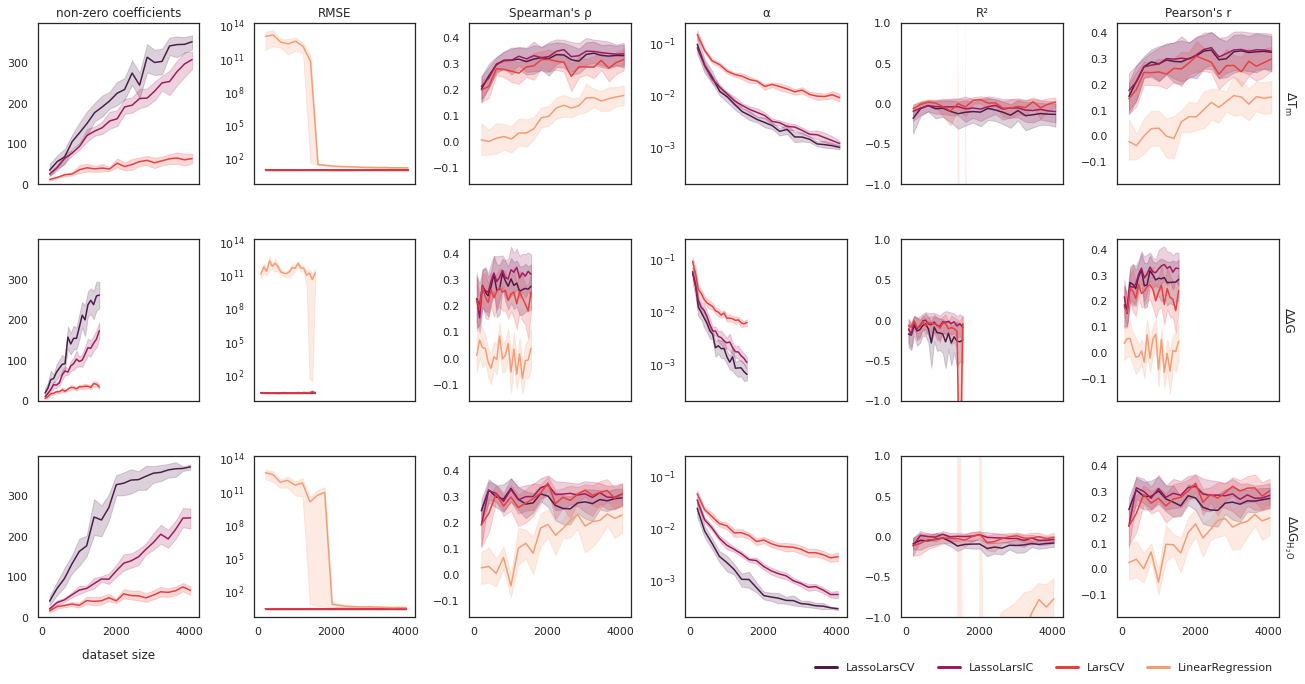

In [237]:
g = sns.FacetGrid(data=df,
                  col='box', row='delta',
                  col_order=['n_cols', 'rmse', 'sp', 'alpha', 'r2', 'pcorr'],
                  height=3.2,
                  margin_titles=True, sharex=True, sharey='col')
g.map_dataframe(sns.lineplot, x='x', y='y',
                hue='algo', hue_order=[0, 1, 2, 3], palette=dict(enumerate(dmap)),
                markers=False, dashes=False)

g.set_titles(col_template='{col_name}', row_template='{row_name}')
for ax, lab in zip(g.axes.flatten()[:6],
                   ['non-zero coefficients', 'RMSE', 'Spearman\'s ρ',
                    'α', 'R²', 'Pearson\'s r']):
    ax.set_title(lab)

# mess around with the legend
handles = list()
for de, co in zip('LassoLarsCV LassoLarsIC LarsCV LinearRegression'.split(), dmap):
    handles.append(mlines.Line2D([], [], color=co, label=de, linewidth=3))
g.add_legend(title='', bbox_to_anchor=(.71, 0), ncol=4, handles=handles)

for i, ax in enumerate(g.axes.flatten()):
    ax.set(box_aspect=1)
    # ax.set(xticks=[.2, .4, .6, .8])
    # Drawing the frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)

g.axes[0, 1].set_yscale('log')
g.axes[0, 3].set_yscale('log')
g.axes[0, 4].set_ylim(-1, 1)
g.axes[2, 0].set_xlabel('dataset size', labelpad=12)

# g.fig.subplots_adjust(hspace=.1)
prep.save(g, f'uniprot_split.png')

### looks like correlations are *a lot* worse, re-check for a single experiment

In [ ]:
test_size = .2
seed = rng.integers(low=0, high=1000, size=1)[0]
seed = 797
desc = 'test size: %.1f'
splits = data.uniprot_train_test_split(test_size=test_size, random_state=seed)

store = dict()
ars = list()
for i, (delta, split) in enumerate(splits.items()):
    regr = linear_model.LassoLarsCV(n_jobs=-1, max_iter=2000, cv=20)
    regr.fit(split.X, split.y.flatten())

    # make a prediction
    y_pred = regr.predict(split.X_test).reshape(-1, 1)
    # save the prediction
    ars.append(np.hstack((np.full(y_pred.shape, i), y_pred, split.y_true)))

fig, axes = plt.subplots(1, 3, figsize=(13.6, 6))

for i, (ax, ar) in enumerate(zip(axes, ars)):
    sns.regplot(ax=ax,
                x=ar[:, 1], y=ar[:, 2],
                color=cmap[i],
                # marker='+',
                scatter_kws={'s': 10, 'alpha': .3},
                fit_reg=False, logistic=True)

    ax.set(aspect=1, box_aspect=1)
    # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
    ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

    # correlations
    sp, pval = scipy.stats.spearmanr(ar[:, 1:], axis=0)
    pcorr = np.corrcoef(ar[:, 1:], rowvar=False)[0, 1]
    rmse = mean_squared_error(ar[:, 2], ar[:, 1], squared=False)
    r2 = r2_score(ar[:, 2], ar[:, 1])

    ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
            transform=ax.transAxes)
    axes[0].set_title(desc % test_size, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
axes[0].set(ylabel='true value', xlabel='predicted value')
prep.save(fig, f'uniprot_ts_{test_size}_seed_{seed}.png')

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl
split 797 targeted 0.2, real test sizes: 0.2020:0.2113:0.2057, record test sizes: 0.4470:0.1390:0.1123
